#  Мониторинг процесса обучения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/track/log/log-summary#docusaurus_skipToContent_fallback
* https://docs.wandb.ai/guides/track/log/log-models
* https://www.youtube.com/playlist?list=PLD80i8An1OEGajeVo15ohAQYF1Ttle0lk

## Задачи для совместного разбора

In [1]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kekwak. Use `wandb login --relogin` to force relogin


True

1\. Рассмотрите возможности пакета `wandb` по отслеживанию числовых значений, визуализации изображений и таблиц.

In [2]:
import torch as th

def train(num_epochs: int):
    for x in range(num_epochs):
        x = th.tensor(x)
        loss = th.exp(-x/num_epochs)
        r2 = th.randn(size=(1,))
        wandb.log({"train/loss": loss, "train/r2": r2})
    wandb.run.summary["test/r2"] = 1

In [3]:
with wandb.init(
    project="seminar-tutorial",
    # name="run2",
    tags=["demo"],
    config={"num_epochs": 100}
):
    train(100)

train/loss,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train/r2,▆▆▄▄▅▃▇▅▁▅▃▅▃▆▅▄▆█▇▅▆▄▄▁▆▆▃▃▇▇▃▆▃▄▄▄▂▁▅▅
test/r2,1
train/loss,0.37158
train/r2,-1.15717


In [4]:
import seaborn as sns
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

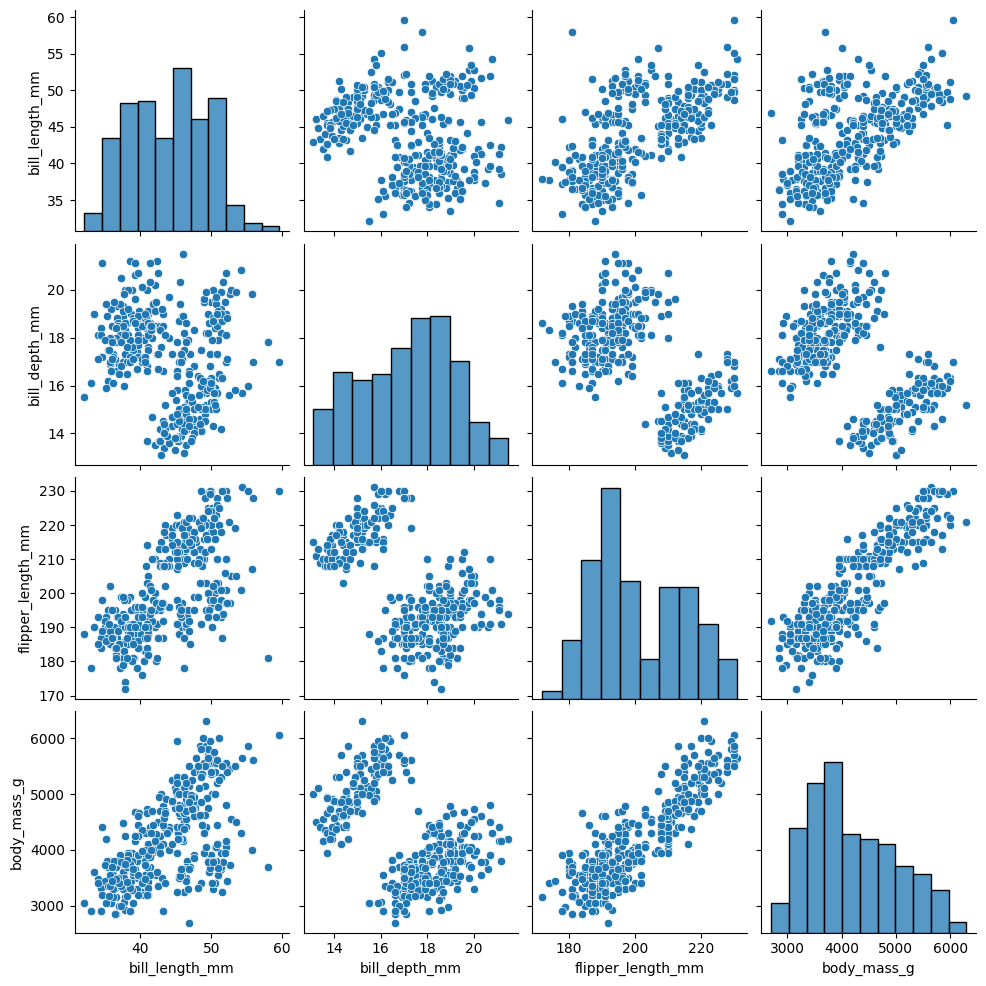

In [5]:
with wandb.init(
    project="seminar-tutorial",
    # name="run2",
    tags=["demo"],
    config={"num_epochs": 100}
):
    dataset = sns.load_dataset("penguins")
    img = sns.pairplot(dataset)
    wandb.log({"train/pairplot": wandb.Image(img.figure)})

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Решите задачу регрессии, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики $R^2$ по эпохам. После завершения обучения рассчитайте значение метрик MSE, RMSE, MAE и MAPE и сохраните в виде summary данного запуска.

Обучите не менее трех моделей (с разной архитектурой или гиперпараметрами), отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).

- [ ] Проверено на семинаре

In [6]:
import torch as  th

X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

In [8]:
train_X, train_y = dataset_train[:][0], dataset_train[:][1]
test_X, test_y = dataset_test[:][0], dataset_test[:][1]
dataloader_train = DataLoader(dataset_train, batch_size=16)
dataloader_test = DataLoader(dataset_test, batch_size=16)

In [9]:
from torch import nn, optim

model_1 = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
critertion_1 = nn.MSELoss()

model_2 = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)
optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
critertion_2 = nn.MSELoss()

model_3 = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)
optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
critertion_3 = nn.MSELoss()

In [10]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, R2Score

def train(model, optimizer, critertion, num_epochs, print_every=40):
    for epoch in range(1, num_epochs+1):
        model.train()
        for x_b, y_b in dataloader_train:
            y_pred = model(x_b)
            loss = critertion(y_pred, y_b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        x, y = dataset_train[:][0], dataset_train[:][1]
        with th.no_grad():
            y_pred = model(x)
            loss = critertion(y_pred, y)
            r2 = R2Score()(y_pred, y)

        wandb.log({"train/loss": loss, "train/r2": r2})
        if epoch % print_every == 0 or epoch == 1:
            print(f'Эпоха {epoch}/{num_epochs}, loss: {loss:.4f}, r2: {r2:.4f}')

    model.eval()
    x, y = dataset_test[:][0], dataset_test[:][1]
    y_pred = model(x)

    metrics = {
        'mse': MeanSquaredError(),
        'rmse': MeanSquaredError(squared=False),
        'mae': MeanAbsoluteError(),
        'mape': MeanAbsolutePercentageError(),
        'r2': R2Score()
    }

    for name, metric in metrics.items():
        wandb.summary[f'test/{name}'] = metric(y_pred, y).item()

In [11]:
config = {"num_epochs": 160, "print_every": 40}
with wandb.init(
    project="seminar-tutorial",
    name="task-1, model-1",
    tags=["task-1"],
    config=config
):
    train(model_1, optimizer_1, critertion_1, **config)

Эпоха 1/160, loss: 0.4338, r2: 0.1381
Эпоха 40/160, loss: 0.1317, r2: 0.7383
Эпоха 80/160, loss: 0.1195, r2: 0.7626
Эпоха 120/160, loss: 0.0998, r2: 0.8016
Эпоха 160/160, loss: 0.0718, r2: 0.8574


train/loss,█▇▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
train/r2,▁▂▃▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
test/mae,0.3516
test/mape,3.55137
test/mse,0.15762
test/r2,0.54491
test/rmse,0.39702
train/loss,0.07179
train/r2,0.85737


In [12]:
config = {"num_epochs": 200, "print_every": 50}
with wandb.init(
    project="seminar-tutorial",
    name="task-1, model-2",
    tags=["task-1"],
    config=config
):
    train(model_2, optimizer_2, critertion_2, **config)

Эпоха 1/200, loss: 0.4307, r2: 0.1443
Эпоха 50/200, loss: 0.0272, r2: 0.9460
Эпоха 100/200, loss: 0.0271, r2: 0.9462
Эпоха 150/200, loss: 0.0270, r2: 0.9464
Эпоха 200/200, loss: 0.0269, r2: 0.9466


train/loss,█▇▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/r2,▁▆▆▇▇███████████████████████████████████
test/mae,0.18294
test/mape,1.26094
test/mse,0.06867
test/r2,0.80173
test/rmse,0.26205
train/loss,0.02687
train/r2,0.94661


In [13]:
config = {"num_epochs": 320, "print_every": 80}
with wandb.init(
    project="seminar-tutorial",
    name="task-1, model-3",
    tags=["task-1"],
    config=config
):
    train(model_3, optimizer_3, critertion_3, **config)

Эпоха 1/320, loss: 0.2777, r2: 0.4483
Эпоха 80/320, loss: 0.0019, r2: 0.9962
Эпоха 160/320, loss: 0.0011, r2: 0.9978
Эпоха 240/320, loss: 0.0019, r2: 0.9963
Эпоха 320/320, loss: 0.0005, r2: 0.9989


train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/r2,▁▁▅▅▇███████████████████████████▇▇▇█████
test/mae,0.02555
test/mape,0.24401
test/mse,0.00089
test/r2,0.99742
test/rmse,0.0299
train/loss,0.00054
train/r2,0.99892


In [14]:
from torch import nn, optim

model_1 = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
critertion_1 = nn.MSELoss()

model_2 = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)
optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
critertion_2 = nn.MSELoss()

model_3 = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)
optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
critertion_3 = nn.MSELoss()

**Графики обучения**
![Снимок экрана 2024-10-22 в 20.43.44.png](<attachment:Снимок экрана 2024-10-22 в 20.43.44.png>)

Описание | Скриншоты
---------|----------
**Модель 1:**<br>160 эпох + вывод каждые 40 эпох<br>`Linear(1, 16) -> ReLU() -> Linear(16, 1)` | ![Снимок экрана 2024-10-22 в 20.44.27.png](<attachment:Снимок экрана 2024-10-22 в 20.44.27.png>) ![Снимок экрана 2024-10-22 в 20.44.39.png](<attachment:Снимок экрана 2024-10-22 в 20.44.39.png>)
**Модель 2:**<br>200 эпох + вывод каждые 50 эпох<br>`Linear(1, 32) -> ReLU() -> Linear(32, 4) -> ReLU() -> Linear(4, 1)` | ![Снимок экрана 2024-10-22 в 20.45.28.png](<attachment:Снимок экрана 2024-10-22 в 20.45.28.png>) ![Снимок экрана 2024-10-22 в 20.45.50.png](<attachment:Снимок экрана 2024-10-22 в 20.45.50.png>)
**Модель 3:**<br>320 эпох + вывод каждые 80 эпох<br>`Linear(1, 128) -> ReLU() -> Linear(128, 64) -> ReLU() -> Linear(64, 32) -> ReLU() -> Linear(32, 1)` | ![Снимок экрана 2024-10-22 в 20.46.25.png](<attachment:Снимок экрана 2024-10-22 в 20.46.25.png>) ![Снимок экрана 2024-10-22 в 20.46.41.png](<attachment:Снимок экрана 2024-10-22 в 20.46.41.png>)
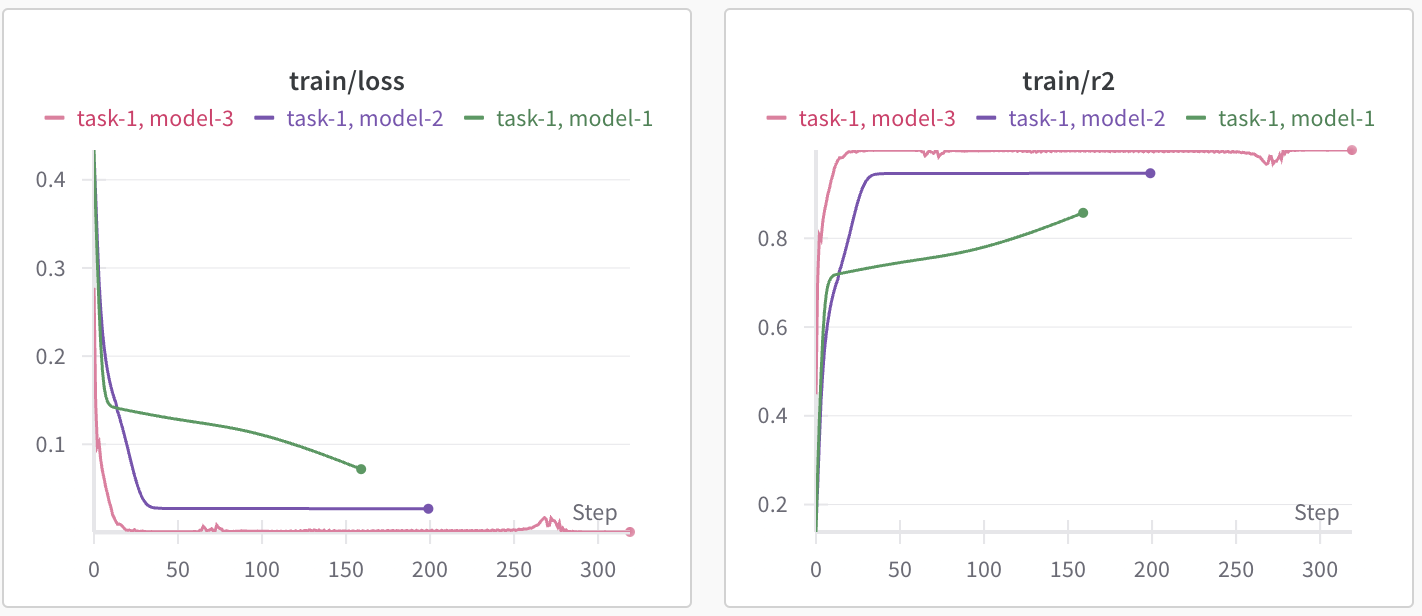
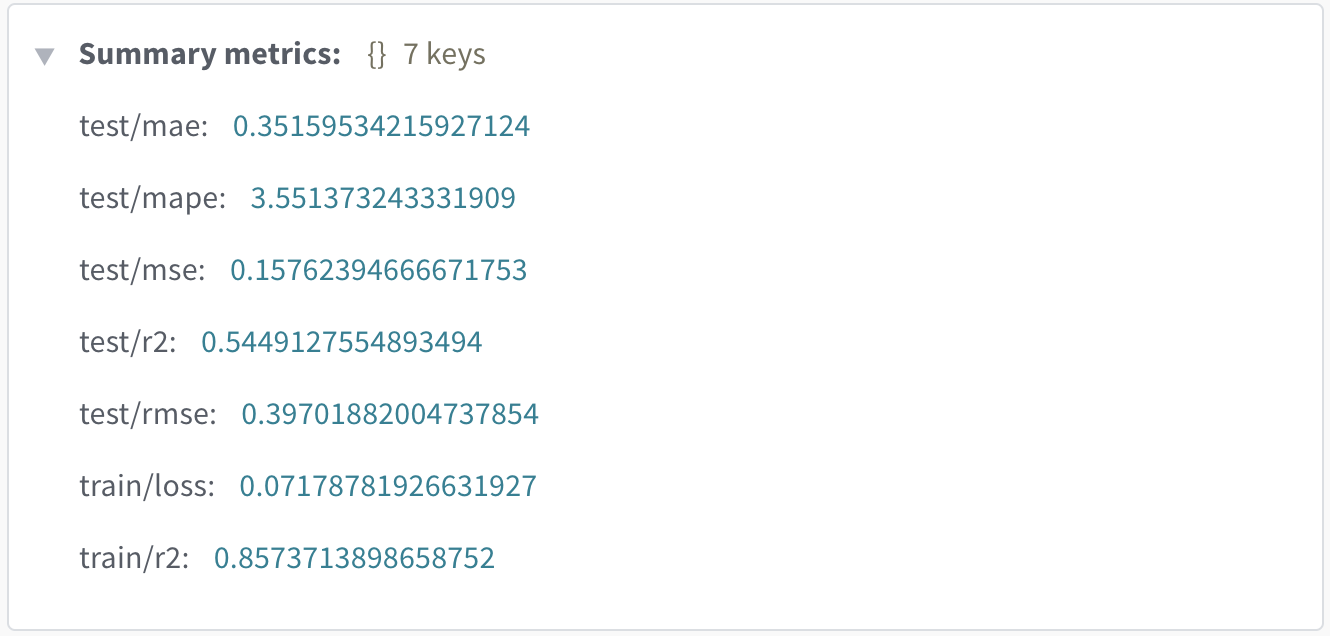
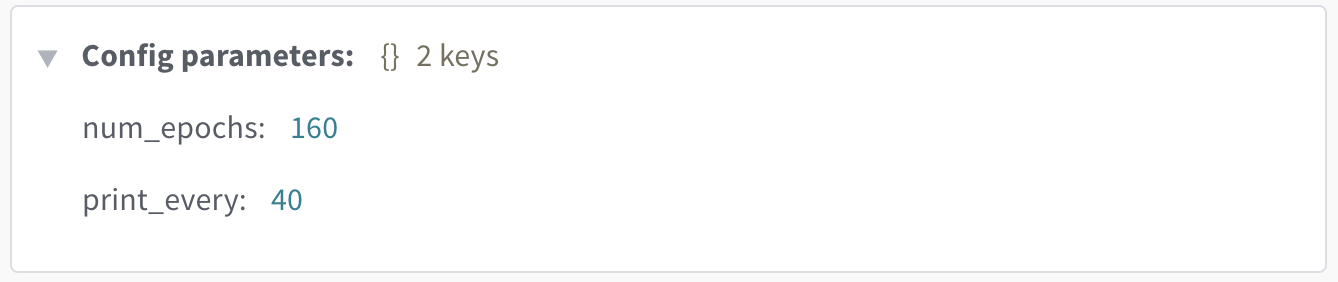
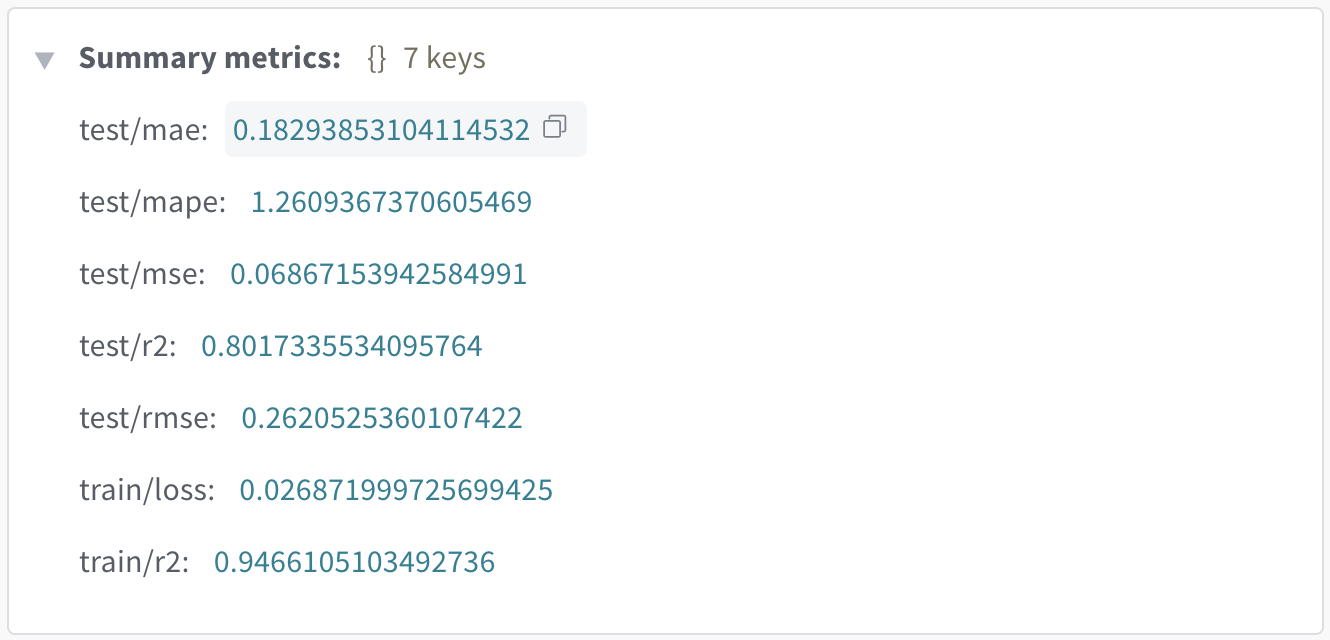
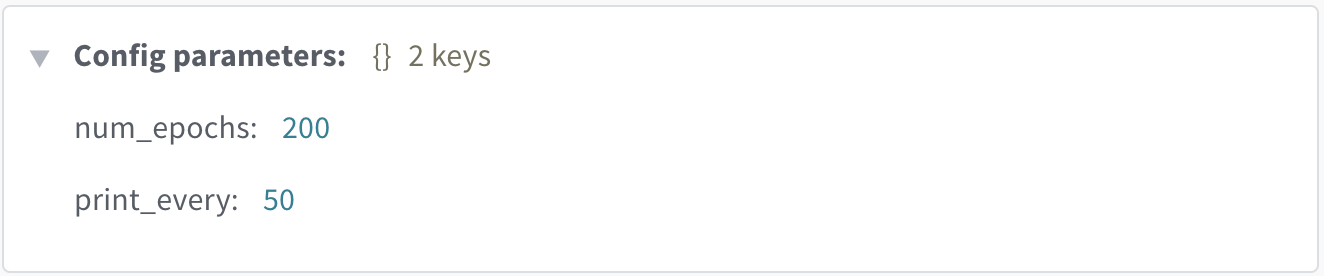
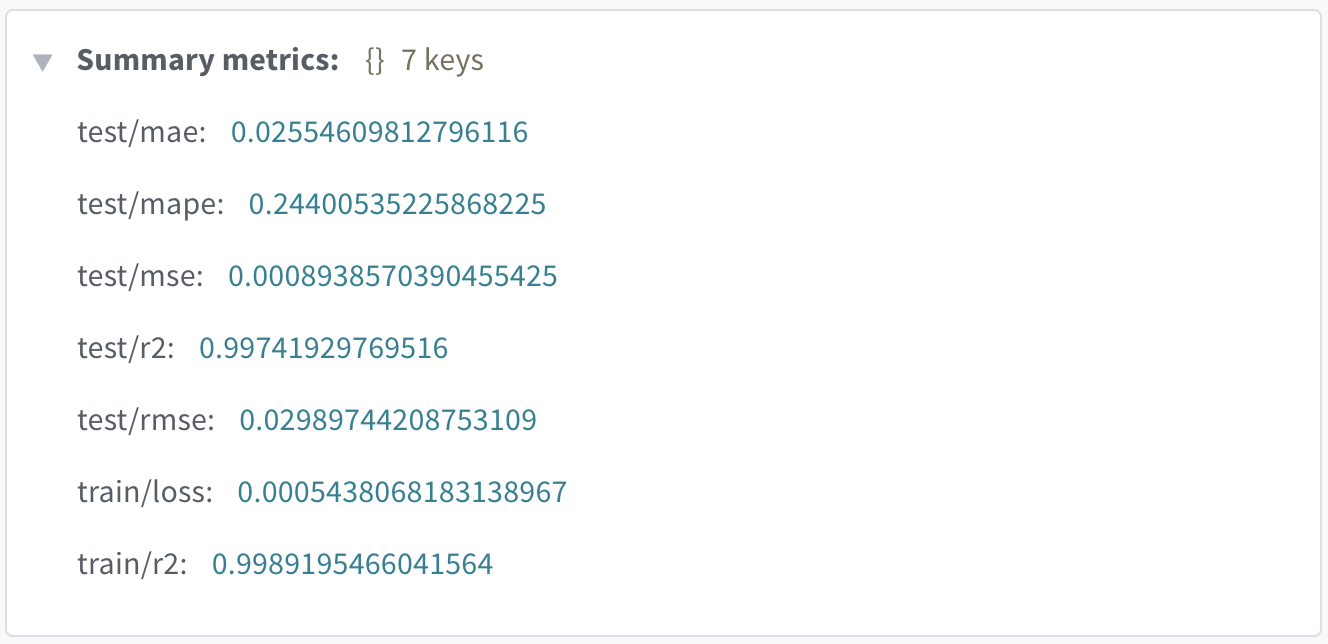
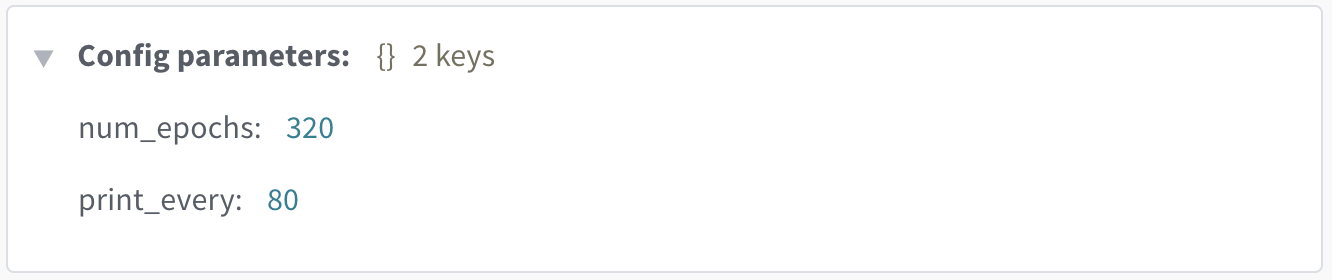

<p class="task" id="2"></p>

2\. Решите задачу классификации, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики `Accuracy` по эпохам. После завершения обучения рассчитайте значение метрик Accuracy, Precision, Recall и F1 и сохраните в виде summary данного запуска.

Отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).


- [ ] Проверено на семинаре

In [15]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

<p class="task" id="3"></p>

3\. Повторите задачу 2, вычислив и визуализировав матрицу несоответствий (для обучающей и тестовой выборки) тремя способами при помощи `wandb`:
* используя `torchmetrics` и представив данные в виде объекта `wandb.Table`;
* используя готовую функцию `wandb.plot.confusion_matrix`;
* построив тепловую карту при помощи `seaborn` и представив данные в виде объекта `wandb.Image`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

<p class="task" id="4"></p>

4\. Повторите задачу 2, обучив две модели: линейную и нелинейную. Для каждой из моделей сделайте прогноз (по всей выборке) и визуализируйте облако точек в виде `wandb.Image` (раскрасьте точки в цвета, соответствующие прогнозам модели).

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

<p class="task" id="5"></p>

5\. Повторите задачу 2, реализовав логику ранней остановки. Для этого разделите данные на три части: обучающую, валидационную и тестовую. Остановите процесс обучения, если целевая метрика (F1) на валидации не увеличивалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи. Сохраните номер эпохи, на которой процесс обучения был прерван, в виде summary данного запуска.

Помимо отслеживания метрик на обучающей и тестовой выборке, также отслеживайте метрики на валидационной выборке в процессе обучения.

Постройте таблицу `wandb.Table`, в которой содержится информация о:
* признаках объекта;
* правильном ответе;
* прогнозе модели;
* принадлежности к обучающему, валидационному или тестовому множеству.

Визуализируйте данную таблицу при помощи `wandb`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.

- [ ] Проверено на семинаре
